# FETAL CARDIOTOCOGRAPHY CLASSIFICATION

The objective of this analysis is to indicate the conditions under which fetal health is determined to be suspect or pathological. The data is derived from fetal cardiotocographic monitors which measure the vitals of a fetus in utero. Additional analytical features have been added to the dataset. <br><br>

The analysis will attempt to show which features have the greatest impact on our ability to determine the class in the “NSP” feature. As such, the analysis will prioritize interpretability over predictive power.  The error metric to be used for evaluating the models will be “recall” as we want to reduce the occurrence of false negatives. In other words it is better to falsely label a “Normal” pattern as “Suspect” or “Pathological” than to falsely label a “Suspect” or “Pathological” pattern as “Normal.”

# Prelim

In [11]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib inline
sns.set_style('white')

from joblib import Parallel, delayed
import multiprocessing

In [12]:
data_raw = pd.read_csv('CTG.csv')

In [13]:
data_raw.columns

Index(['FileName', 'Date', 'SegFile', 'b', 'e', 'LBE', 'LB', 'AC', 'FM', 'UC',
       'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DS', 'DP', 'DR', 'Width', 'Min',
       'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 'Variance',
       'Tendency', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP',
       'CLASS', 'NSP'],
      dtype='object')

An overview of the features is as follows.<br>
_(see [appendix](#Full-List-of-Features-with-Definitions) for a detailed listing of features with definitions)_ <br><br>

__Date__  - Date of examination <br><br>

__b, e__ - Timestamp features indicating the beginning and end of the reading <br><br>

__AC, FM, UC, DL, DS, DP, DR__ - Features counting the occurrences of certain indicators (ex. Fetal movements, uterine contractions)<br><br>

__LBE, LB, ASTV, mSTV, ALTV, MLTV__ - Analytical features indicating baseline values of fetal heart rate, as well as averages and percentages of heart rate variability<br><br>

__Width, Min, Max, Nmax, Nzeros, Mode, Mean, Median, Variance, Tendency__ - Analytical features indicating the size and shape of the histogram of fetal heart rate. “Nmax” and “Nzeros” are respectively a count of the local maxima and of the zero values.<br><br>

__NSP__  - Classification feature indicating whether the fetal health is:
* 1 - Normal<br>
* 2 - Suspect<br>
* 3 - Pathological<br>

In [14]:
remove_cols = ['FileName', 'Date', 'SegFile', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP','CLASS']
data = data_raw.drop(labels=remove_cols, axis=1)

# EDA:

In [15]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
b,2126.0,878.439793,894.084748,0.0,55.0,538.0,1521.00,3296.0
e,2126.0,1702.877234,930.919143,287.0,1009.0,1241.0,2434.75,3599.0
LBE,2126.0,133.303857,9.840844,106.0,126.0,133.0,140.00,160.0
LB,2126.0,133.303857,9.840844,106.0,126.0,133.0,140.00,160.0
AC,2126.0,2.722484,3.560850,0.0,0.0,1.0,4.00,26.0
FM,2127.0,7.503056,39.030452,0.0,0.0,0.0,2.00,564.0
UC,2127.0,3.669017,2.877148,0.0,1.0,3.0,5.00,23.0
ASTV,2127.0,47.008933,17.210648,12.0,32.0,49.0,61.00,87.0
MSTV,2127.0,1.335449,0.891543,0.2,0.7,1.2,1.70,7.0
ALTV,2127.0,9.884814,18.476534,0.0,0.0,0.0,11.00,91.0


It appears the features “LB” and “LBE” have the same data points. This was confirmed upon closer inspection, and therefore the redundant feature “LBE” was removed. 

In [16]:
data = data.drop('LBE', axis=1)

The table above show that the 'DR' column consists only of the value zero for every record. Therefore we can remove that feature.

In [17]:
#Remove 'DR' column
data = data.drop('DR', axis=1)

### Remove Nulls

In [18]:
#Select Nulls
data_nulls = data[data.isnull().any(axis=1)].index

#Remove Nulls
data = data.drop(data_nulls, axis=0)

data.isnull().values.any()

False

### Convert integers to integer datatype

The data types shown below indicate that all features are coded as floats, even though most are integers. For those instances we should change the features to integer data type.

In [19]:
data.dtypes

b           float64
e           float64
LB          float64
AC          float64
FM          float64
UC          float64
ASTV        float64
MSTV        float64
ALTV        float64
MLTV        float64
DL          float64
DS          float64
DP          float64
Width       float64
Min         float64
Max         float64
Nmax        float64
Nzeros      float64
Mode        float64
Mean        float64
Median      float64
Variance    float64
Tendency    float64
NSP         float64
dtype: object

In [20]:
# Select Rows that have decimal values (i.e. non-integer)
float_cols = data[data != round(data,0)].any()
int_list = list(float_cols[float_cols == False].index)
int_list

['b',
 'e',
 'LB',
 'AC',
 'FM',
 'UC',
 'ASTV',
 'ALTV',
 'DL',
 'DS',
 'DP',
 'Width',
 'Min',
 'Max',
 'Nmax',
 'Nzeros',
 'Mode',
 'Mean',
 'Median',
 'Variance',
 'Tendency',
 'NSP']

In [21]:
#convert columns with no decimals to integer

for columns in int_list:
    data[columns] = data[columns].astype(int)

In [22]:
data.dtypes

b             int32
e             int32
LB            int32
AC            int32
FM            int32
UC            int32
ASTV          int32
MSTV        float64
ALTV          int32
MLTV        float64
DL            int32
DS            int32
DP            int32
Width         int32
Min           int32
Max           int32
Nmax          int32
Nzeros        int32
Mode          int32
Mean          int32
Median        int32
Variance      int32
Tendency      int32
NSP           int32
dtype: object

In [24]:
#remove beginning and end timstamps
data_pp = data.drop(['b', 'e'], axis=1)

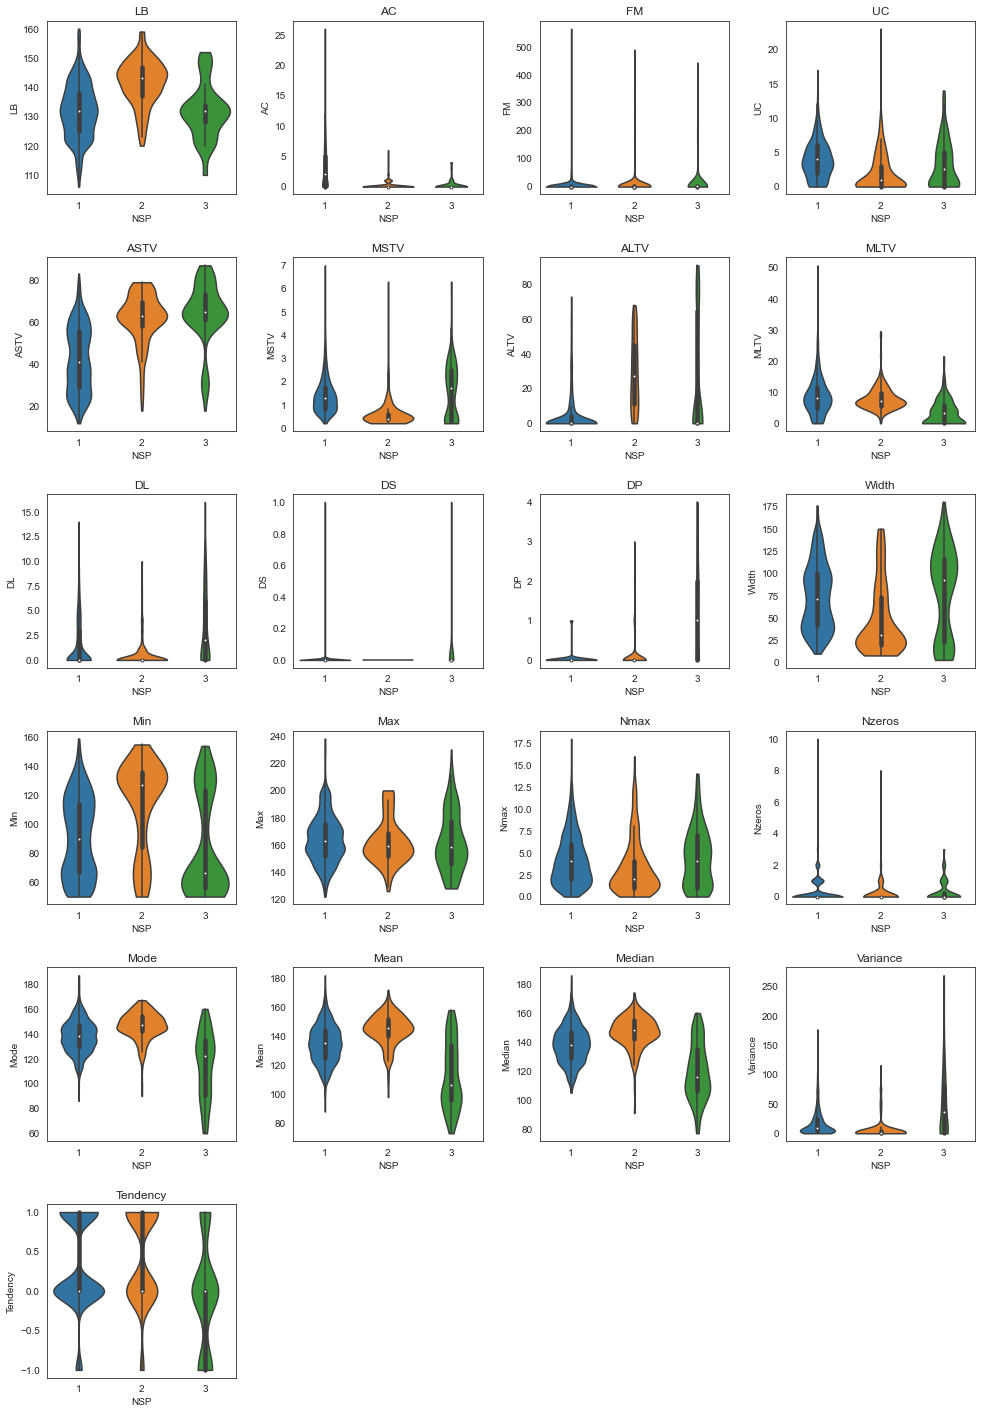

In [25]:
c = 1  # initialize plot counter

fig = plt.figure(figsize=(14,20))

for i in data_pp.columns[:-1]:
    plt.subplot(6, 4, c)
    plt.title(f'{i}')
    sns.violinplot(data=data, y=i, x='NSP', cut=0)
    c = c + 1

fig.tight_layout(pad=2.0)

The durations of the readings differs for all the records. Therefore, we need to calculate the duration of the reading instance by finding the time disatnce between the start ('s') feature and the end ('e') feature. This new feature will be called 'instant_dur'.<br><br>

We will then find all features that are a count of a behavior, then divide by the duration. In other words, one would expect the count of instances of a behavior to correlate with the duration of the reading. We should expect to see a reduction in skew and kurtosis as a result.

In [14]:
from scipy.stats import  skew, kurtosis, mode

kurtosis: 8.7317
skew: 1.3543


<AxesSubplot:title={'center':'Histogram of Instant Durations'}, xlabel='Duration of Instant', ylabel='Count'>

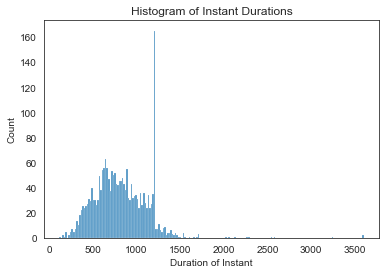

In [15]:
# calculate duration of instant
data['instant_dur'] = data['e'] - data['b']

print(f"kurtosis: {round(kurtosis(data['instant_dur']),4)}")
print(f"skew: {round(skew(data['instant_dur']),4)}")

plt.title('Histogram of Instant Durations')
plt.xlabel('Duration of Instant')
sns.histplot(data=data, x='instant_dur', bins=200)

In [16]:
mode(data['instant_dur'])

ModeResult(mode=array([1199]), count=array([150]))

The histogram clearly shows a flaw in the data wherein an abnormal count of readings have a duration of exactly 1199. In order to fully understand this abnormality, the cardiotocography device would need to inspected. For our purposes we will assume it is due to the fact that the machine stops recording just before it reaches a duration of 20 hours (or 1200 minutes). 

All the records with a duration of 1199 are problematic. Though the majority of these records are probably incomplete readings, there could be actual records that are complete and properly lasted for a duration of 1199. Unfortunately it is not possible to determine which is which, so it is probably best to remove all records with this duration.

In [17]:
data_trim = data[data['instant_dur']!=1199]

In [18]:
# columns that are a COUNT of a behavior

sum_cols = data[['AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'Nmax', 'Nzeros']].columns

In [19]:
data[sum_cols].corrwith(data['instant_dur'])

AC        0.330838
FM        0.028391
UC        0.519352
DL        0.229195
DS        0.020675
DP        0.072802
Nmax      0.120304
Nzeros   -0.015493
dtype: float64

In [20]:
for cols in sum_cols:
    data[cols + '_fq'] = (data[cols]/data['instant_dur'])*100

In [21]:
sum_cols_fq = []

for cols in sum_cols:
    sum_cols_fq.append(cols)
    sum_cols_fq.append(cols+'_fq')

In [22]:
sum_cols_data_scaled = data[sum_cols_fq]
sum_cols_data_scaled = pd.concat([sum_cols_data_scaled, data['NSP']], axis=1)
sum_cols_data_scaled.head()

,AC,AC_fq,FM,FM_fq,UC,UC_fq,DL,DL_fq,DS,DS_fq,DP,DP_fq,Nmax,Nmax_fq,Nzeros,Nzeros_fq,NSP
0,0,0.000000,0,0.0,0,0.000000,0,0.000000,0,0.0,0,0.0,2,1.709402,0,0.000000,2
1,4,0.637959,0,0.0,4,0.637959,2,0.318979,0,0.0,0,0.0,6,0.956938,1,0.159490,1
2,2,0.332226,0,0.0,5,0.830565,2,0.332226,0,0.0,0,0.0,5,0.830565,1,0.166113,1
3,2,0.256082,0,0.0,6,0.768246,2,0.256082,0,0.0,0,0.0,11,1.408451,0,0.000000,1
4,4,0.651466,0,0.0,5,0.814332,0,0.000000,0,0.0,0,0.0,9,1.465798,0,0.000000,1


In [23]:
df_test = pd.DataFrame({'Vals': np.concatenate([np.random.randint(0, 200, size=1000),
                                           np.random.randint(400, 700, size=100),
                                           np.arange(600, 620)])})
df_test['x'] = np.random.randint(0, 3, len(df_test))
df_test.head()

,Vals,x
0,173,0
1,49,2
2,195,1
3,155,0
4,156,0


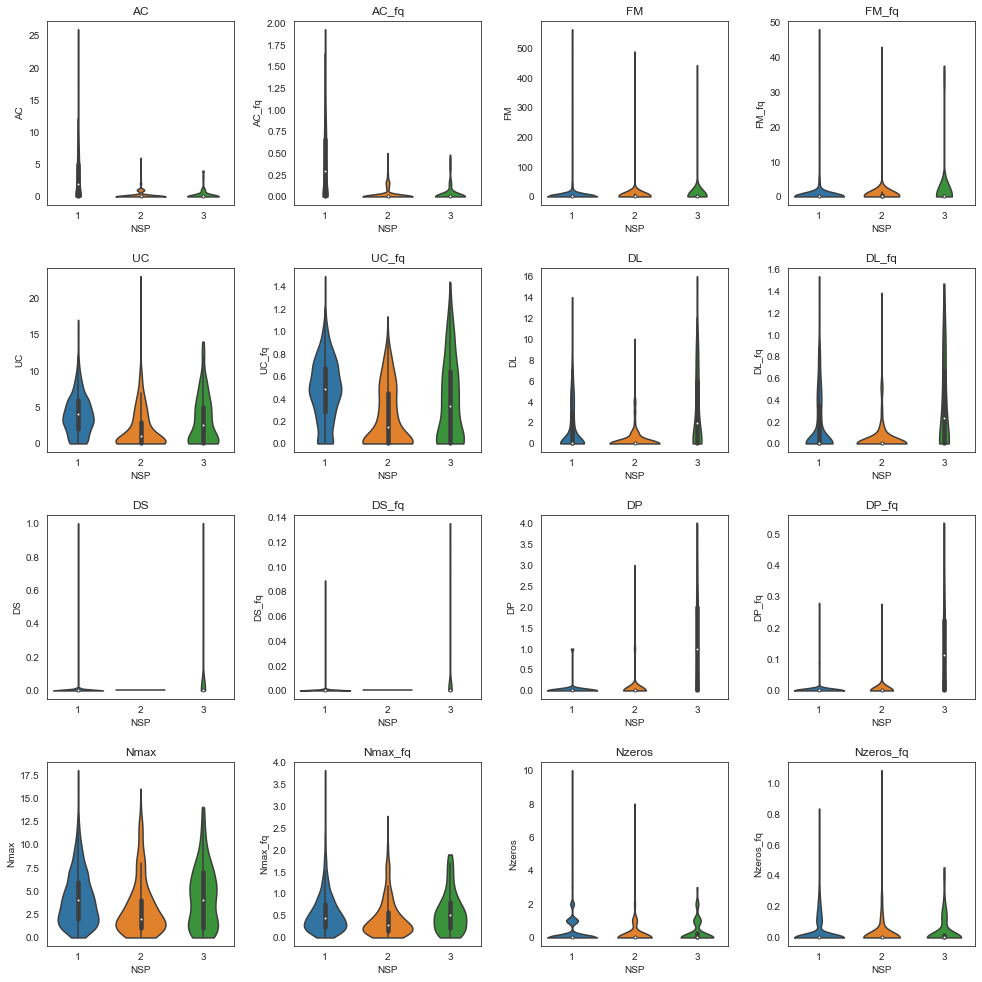

In [24]:
c = 1  # initialize plot counter

fig = plt.figure(figsize=(14,14))

for i in sum_cols_fq:
    plt.subplot(4, 4, c)
    plt.title('{}'.format(i))
    plt.xlabel(i)
    sns.violinplot(data=sum_cols_data_scaled, y=i, x='NSP', cut=0)
    c = c + 1

fig.tight_layout(pad=2.0)

In [25]:
k_s = np.repeat(np.array(['Kurtosis', 'Skew']),4)
o_s_d_p = np.tile(np.array(['Original', 'Scaled', 'Difference', 'Pct_Diff']),2)
s_k_metrics = pd.DataFrame(index=[k_s, o_s_d_p])

for cols in sum_cols:
    unscaled_cols = sum_cols_data_scaled[cols]
    scaled_cols = sum_cols_data_scaled[cols+"_fq"]
    s_k_metrics = pd.concat([s_k_metrics, pd.Series(
        {("Kurtosis", "Original"):  kurtosis(unscaled_cols), 
        ("Kurtosis", "Scaled"):     kurtosis(scaled_cols), 
        ("Kurtosis", "Difference"): kurtosis(scaled_cols) - kurtosis(unscaled_cols),
        ("Kurtosis", "Pct_Diff"):   (kurtosis(scaled_cols) - kurtosis(unscaled_cols)) / kurtosis(unscaled_cols),
        ("Skew", "Original"):       skew(unscaled_cols), 
        ("Skew", "Scaled"):         skew(scaled_cols), 
        ("Skew", "Difference"):     skew(scaled_cols) - skew(unscaled_cols),
        ("Skew", "Pct_Diff"):       (skew(scaled_cols) - skew(unscaled_cols)) / skew(unscaled_cols)},
            name=cols)], axis=1)

s_k_metrics = s_k_metrics.T
s_k_metrics

Kurtosis                                        Skew             \
          Original      Scaled Difference  Pct_Diff   Original     Scaled   
AC        3.112334    0.779710  -2.332624 -0.749477   1.657659   1.209231   
FM      104.385626   64.113096 -40.272530 -0.385805   9.420843   7.806644   
UC        1.283403   -0.650755  -1.934158 -1.507055   0.834757   0.156266   
DL        3.136630    2.497658  -0.638972 -0.203713   1.817836   1.720355   
DS      298.717589  320.327281  21.609692  0.072342  17.341211  17.799132   
DP       19.172450   20.027846   0.855396  0.044616   4.232899   4.275781   
Nmax      0.500205    4.645230   4.145026  8.286660   0.892256   1.739340   
Nzeros   30.290897   16.814344 -13.476553 -0.444904   3.917521   3.431430   

                             
       Difference  Pct_Diff  
AC      -0.448429 -0.270519  
FM      -1.614199 -0.171343  
UC      -0.678491 -0.812800  
DL      -0.097480 -0.053624  
DS       0.457922  0.026407  
DP       0.042882  0.010131  
Nmax     0.847085  0.949374  
Nzeros  -0.486090 -0.124081

# Prepare Data for Modeling

## Retain Only Predictor Variables

In [26]:
feature_cols = data.drop(sum_cols, axis=1).columns
feature_cols = feature_cols.drop(['b', 'e', 'NSP', 'instant_dur', 'LBE'])
feature_cols

Index(['LB', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width', 'Min', 'Max', 'Mode',
       'Mean', 'Median', 'Variance', 'Tendency', 'AC_fq', 'FM_fq', 'UC_fq',
       'DL_fq', 'DS_fq', 'DP_fq', 'Nmax_fq', 'Nzeros_fq'],
      dtype='object')

## Test-Train Split

In [27]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(copy=False)

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=531)
train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data['NSP']))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
X_train_scaled = pd.DataFrame(pt.fit_transform(X_train), columns=feature_cols)
y_train = data.loc[train_idx, 'NSP']

X_test  = data.loc[test_idx, feature_cols]
X_test_scaled = pd.DataFrame(pt.transform(X_test), columns=feature_cols)
y_test  = data.loc[test_idx, 'NSP']

In [28]:
print('Training Set Class Distribution')
print(f'{y_train.value_counts(normalize=True)}')
print('Test Set Class Distribution')
print(f'{y_test.value_counts(normalize=True)}')

Training Set Class Distribution
1    0.778226
2    0.139113
3    0.082661
Name: NSP, dtype: float64
Test Set Class Distribution
1    0.778997
2    0.137931
3    0.083072
Name: NSP, dtype: float64


In [29]:
y_test.value_counts()

1    497
2     88
3     53
Name: NSP, dtype: int64

## Balance the Classes

In [30]:
# Not doing undersampling because we don't have a lot of samples to begin with

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek

X_train_SMOTE, y_train_SMOTE = SMOTE(random_state=531).fit_resample(X_train_scaled, y_train)
X_train_ADASYN, y_train_ADASYN = ADASYN(random_state=531).fit_resample(X_train_scaled, y_train)
X_train_SMOTEENN, y_train_SMOTEENN = SMOTEENN(random_state=531).fit_resample(X_train_scaled, y_train)
X_train_SMOTETomek, y_train_SMOTETomek = SMOTETomek(random_state=531).fit_resample(X_train_scaled, y_train)

sampler_labels = ['SMOTE', 'ADASYN', 'SMOTE-ENN', 'SMOTE-Tomek']
Xtrains = [X_train_SMOTE, X_train_ADASYN, X_train_SMOTEENN, X_train_SMOTETomek]
ytrains = [y_train_SMOTE, y_train_ADASYN, y_train_SMOTEENN, y_train_SMOTETomek]

In [31]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred, average='macro'),
                      'recall': recall_score(y_true, y_pred, average='macro'),
                      'f1': f1_score(y_true, y_pred, average='macro')},
                      name=label)

# Model 1 - Logistic Regression

## Define Logistic Regression Models w/ L1 & L2 Regularization

In [32]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

lr = LogisticRegression(solver='liblinear')

lr_l1 = LogisticRegressionCV(
    Cs=10, cv=4, penalty='l1',
    max_iter=1000, solver='liblinear', 
    scoring='recall_macro', n_jobs=-1)

lr_l2 = LogisticRegressionCV(
    Cs=10, cv=4, penalty='l2', 
    max_iter=1000, solver='liblinear', 
    scoring='recall_macro', n_jobs=-1)

## 1a - Evaluate Models w/ Classes Imbalanced

### Fit Models

In [71]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['Lr', 'L1', 'L2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.fit(X_train_scaled, y_train).coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2]], 
                                 codes=[[0,0,0], [0,1,2]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1).set_index(feature_cols)

In [72]:
for class_num in coefficients.columns:
    print(class_num, len(coefficients[coefficients[class_num] != 0]), 'coefficients')

('Lr', 0) 21 coefficients
('Lr', 1) 21 coefficients
('Lr', 2) 21 coefficients
('L1', 0) 21 coefficients
('L1', 1) 21 coefficients
('L1', 2) 21 coefficients
('L2', 0) 21 coefficients
('L2', 1) 21 coefficients
('L2', 2) 21 coefficients


### Predict and Score

In [73]:
y_pred = list()

coeff_labels = ['Lr', 'L1', 'L2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test_scaled), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)

In [74]:
metrics = list()
cm = dict()

for lab in coeff_labels:

    # Precision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='macro')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[1,2,3]),
              label_binarize(y_pred[lab], classes=[1,2,3]), 
              average='macro')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

In [75]:
metrics

,Lr,L1,L2
precision,0.875906,0.876323,0.809971
recall,0.768461,0.780985,0.779551
fscore,0.813264,0.821414,0.787418
accuracy,0.913793,0.915361,0.888715
auc,0.836853,0.845176,0.848134


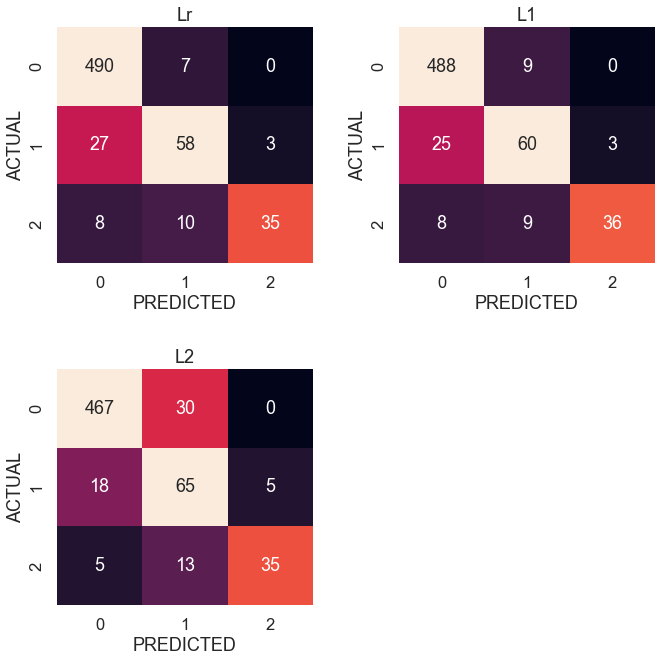

In [78]:
sns.set_context('talk')

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, vmax=55, annot=True, fmt='d', cbar=False)
    ax.set(title=lab)
    ax.set_xlabel('PREDICTED')
    ax.set_ylabel('ACTUAL')
    
plt.tight_layout(pad=2.0)

Confusion matrix shows class 1 is frequently misclassed as class 0. Need to control for the imbalance in classes.

### Evaluate Coefficients

In [39]:
coefficients_L1 = coefficients['L1']
coefficients_L1['importances'] = abs(coefficients_L1[0]) + abs(coefficients_L1[1]) + abs(coefficients_L1[2])
coefficients_L1 = coefficients_L1.sort_values(by='importances', ascending=False)
coefficients_L1 = coefficients_L1.reset_index().reset_index()
coefficients_L1 = coefficients_L1.rename(columns={'level_0':'feature_count', 'index':'Feature'})
coefficients_L1

C:\Users\14126\AppData\Local\Temp/ipykernel_38336/2207554166.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coefficients_L1['importances'] = abs(coefficients_L1[0]) + abs(coefficients_L1[1]) + abs(coefficients_L1[2])


,feature_count,Feature,0,1,2,importances
0,0,Width,2.364759,-0.016777,-4.226773,6.608310
1,1,Max,-1.930026,0.751963,2.674626,5.356615
2,2,Min,1.592369,0.176804,-3.470172,5.239345
3,3,Median,1.151704,0.920956,-3.157264,5.229924
4,4,AC_fq,1.950333,-1.561172,-1.522540,5.034046
5,5,LB,-0.188158,-1.443131,2.506182,4.137471
6,6,Mean,-1.491828,1.325751,-1.171346,3.988925
7,7,ASTV,-1.013682,0.387649,1.403504,2.804835
8,8,DP_fq,-1.032807,1.136838,0.506708,2.676352
9,9,DL_fq,0.447376,0.633639,-1.495991,2.577005


<AxesSubplot:xlabel='feature_count', ylabel='importances'>

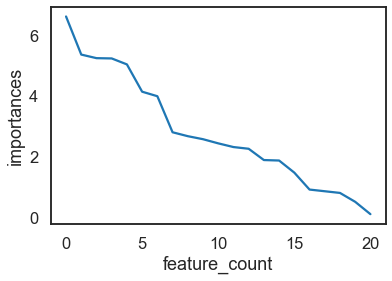

In [40]:
sns.lineplot(data=coefficients_L1, x='feature_count', y='importances')

## 1b - Evaluate L1 Model with Balanced Classes

### Fit Models Based on Oversampling & Undersampling Methods

In [41]:
y_test_pred = pd.DataFrame()
y_train_pred = pd.DataFrame()
coefficients = list()

for lab, Xts, yts in zip(sampler_labels, Xtrains, ytrains):
    loop_start=time.time()
    lr_l1.fit(Xts, yts)
    y_test_pred = pd.concat([y_test_pred, pd.Series(lr_l1.predict(X_test_scaled), name=lab)], axis=1)
    y_train_pred = pd.concat([y_train_pred, pd.Series(lr_l1.predict(Xts), name=lab)], axis=1)
    coeffs = lr_l1.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2]], 
                                 codes=[[0,0,0], [0,1,2]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))
    end = time.time()
    print(f"{lab} time elapsed: {round(end - loop_start, 1)} seconds")

coefficients = pd.concat(coefficients, axis=1).set_index(feature_cols)

SMOTE time elapsed: 2.1 seconds
ADASYN time elapsed: 2.2 seconds
SMOTE-ENN time elapsed: 166.6 seconds
SMOTE-Tomek time elapsed: 153.8 seconds


In [42]:
for class_num in coefficients.columns:
    print(class_num, len(coefficients[coefficients[class_num] != 0]), 'coefficients')

('SMOTE', 0) 21 coefficients
('SMOTE', 1) 21 coefficients
('SMOTE', 2) 20 coefficients
('ADASYN', 0) 21 coefficients
('ADASYN', 1) 21 coefficients
('ADASYN', 2) 21 coefficients
('SMOTE-ENN', 0) 21 coefficients
('SMOTE-ENN', 1) 20 coefficients
('SMOTE-ENN', 2) 21 coefficients
('SMOTE-Tomek', 0) 21 coefficients
('SMOTE-Tomek', 1) 21 coefficients
('SMOTE-Tomek', 2) 20 coefficients


### Predict and Score

In [43]:
error_measures = pd.DataFrame()

for lab, yts in zip(sampler_labels, ytrains):
    error_measures = pd.concat([error_measures, measure_error(y_test, y_test_pred[lab], lab+'_test')], axis=1)
    
error_measures.T

,accuracy,precision,recall,f1
SMOTE_test,0.884013,0.771559,0.839959,0.801334
ADASYN_test,0.860502,0.710539,0.812465,0.749829
SMOTE-ENN_test,0.868339,0.754966,0.846337,0.790582
SMOTE-Tomek_test,0.882445,0.769707,0.839288,0.799832


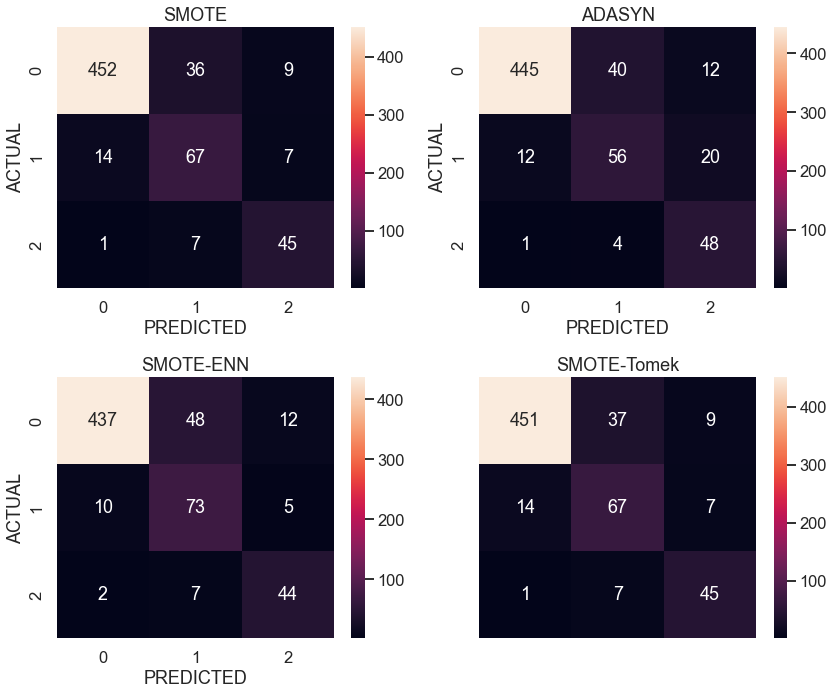

In [44]:
cm = dict()

for lab in sampler_labels:
    cm[lab] = confusion_matrix(y_test, y_test_pred[lab])

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10, 10)

for ax,lab in zip(axList, sampler_labels):
    sns.heatmap(cm[lab], ax=ax, vmax=55, annot=True, fmt='d', cbar=False)
    ax.set(title=lab)
    ax.set_xlabel('PREDICTED')
    ax.set_ylabel('ACTUAL')
    
plt.tight_layout()

### Evaluate Coefficients

In [45]:
# Smote-ENN had the fewest false negatives
coefficients_SMENN = coefficients['SMOTE-ENN']
coefficients_SMENN['importances'] = abs(coefficients_SMENN[0]) + abs(coefficients_SMENN[1]) + abs(coefficients_SMENN[2])
coefficients_SMENN = coefficients_SMENN.sort_values(by='importances', ascending=False)
coefficients_SMENN = coefficients_SMENN.reset_index().reset_index()
coefficients_SMENN = coefficients_SMENN.rename(columns={'level_0':'feature_count'})
coefficients_SMENN

C:\Users\14126\AppData\Local\Temp/ipykernel_38336/2169269593.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coefficients_SMENN['importances'] = abs(coefficients_SMENN[0]) + abs(coefficients_SMENN[1]) + abs(coefficients_SMENN[2])


,feature_count,index,0,1,2,importances
0,0,Median,0.922633,3.439326,-4.517975,8.879934
1,1,LB,-0.587777,-3.079005,4.122341,7.789124
2,2,Width,3.698350,0.574140,-1.610843,5.883333
3,3,AC_fq,2.794890,-1.872881,-0.840252,5.508024
4,4,Variance,-2.335599,-1.021200,1.239520,4.596319
5,5,Max,-2.753790,0.498913,1.108139,4.360843
6,6,MSTV,1.446365,-2.560028,0.078933,4.085325
7,7,DL_fq,1.280542,1.184288,-1.557026,4.021857
8,8,DP_fq,-1.466428,1.856933,0.606741,3.930102
9,9,MLTV,0.788923,1.943502,-0.987936,3.720362


<AxesSubplot:xlabel='feature_count', ylabel='importances'>

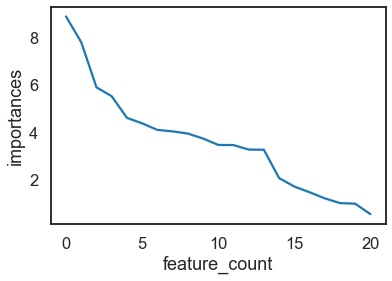

In [46]:
sns.lineplot(data=coefficients_SMENN, x='feature_count', y='importances')

## 1c - Add polynomial features (degree 2)

In [133]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2, include_bias=False)

X_train_poly = pd.DataFrame(poly.fit_transform(X_train), columns=poly.get_feature_names_out())
X_test_poly = pd.DataFrame(poly.fit_transform(X_test), columns=poly.get_feature_names_out())

feature_cols_poly = poly.get_feature_names_out()

X_train_scaled_poly = pd.DataFrame(pt.fit_transform(X_train_poly), columns=feature_cols_poly)
X_test_scaled_poly = pd.DataFrame(pt.transform(X_test_poly), columns=feature_cols_poly)


c:\Users\14126\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [134]:
X_test_scaled_poly.head()

,LB,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Mode,Mean,...,DS_fq^2,DS_fq DP_fq,DS_fq Nmax_fq,DS_fq Nzeros_fq,DP_fq^2,DP_fq Nmax_fq,DP_fq Nzeros_fq,Nmax_fq^2,Nmax_fq Nzeros_fq,Nzeros_fq^2
0,0.871353,-0.203735,-0.338581,-0.824228,-0.220224,-0.499479,1.101694,0.591149,0.677850,0.930533,...,-0.051917,-0.036686,-0.051917,-0.044947,-0.307444,-0.306414,-0.178606,-0.730453,-0.519226,-0.515248
1,0.058668,0.366936,0.778487,-0.824228,-1.617117,0.457373,-0.310753,0.211155,0.247753,-0.229826,...,-0.051917,-0.036686,-0.051917,-0.044947,-0.307444,-0.306414,-0.178606,0.043486,-0.519226,-0.515248
2,-0.552941,0.084392,-0.176992,-0.824228,0.716643,0.802733,-1.185519,-0.197843,-0.088426,0.040144,...,-0.051917,-0.036686,-0.051917,-0.044947,-0.307444,-0.306414,-0.178606,0.058845,-0.519226,-0.515248
3,0.465400,0.644509,1.322504,-0.824228,-1.499757,0.945000,-1.394500,-0.077826,-1.290878,-1.858223,...,-0.051917,-0.036686,-0.051917,-0.044947,3.365957,3.314340,5.600418,1.843460,2.308061,2.263013
4,0.160425,1.025695,-0.913921,-0.824228,0.508129,-0.752902,0.863565,-0.320520,0.531204,0.323362,...,-0.051917,-0.036686,-0.051917,-0.044947,-0.307444,-0.306414,-0.178606,-0.195419,-0.519226,-0.515248


In [218]:
"""X_train_poly_SMOTE, y_train_poly_SMOTE = SMOTE(random_state=531).fit_resample(X_train_scaled_poly, y_train)
X_train_poly_Tomek, y_train_poly_Tomek = TomekLinks().fit_resample(X_train_scaled_poly, y_train)
X_train_poly_ENN, y_train_poly_ENN = EditedNearestNeighbours().fit_resample(X_train_scaled_poly, y_train)
X_train_poly_SMOTEENN, y_train_poly_SMOTEENN = SMOTEENN(random_state=531).fit_resample(X_train_scaled_poly, y_train)
X_train_poly_SMOTETomek, y_train_poly_SMOTETomek = SMOTETomek(random_state=531).fit_resample(X_train_scaled_poly, y_train)
X_train_poly_ADASYN, y_train_poly_ADASYN = ADASYN(random_state=531).fit_resample(X_train_scaled_poly, y_train)

X_trains_poly = [X_train_poly_SMOTE, X_train_poly_ADASYN, X_train_poly_Tomek, 
                 X_train_poly_ENN, X_train_poly_SMOTEENN, X_train_poly_SMOTETomek]
y_trains_poly = [y_train_poly_SMOTE, y_train_poly_ADASYN, y_train_poly_Tomek, 
                 y_train_poly_ENN, y_train_poly_SMOTEENN, y_train_poly_SMOTETomek]"""

In [135]:
X_train_poly_SMOTEENN, y_train_poly_SMOTEENN = SMOTEENN(random_state=531).fit_resample(X_train_scaled_poly, y_train)
X_train_poly_ADASYN, y_train_poly_ADASYN = ADASYN(random_state=531).fit_resample(X_train_scaled_poly, y_train)

X_trains_poly = [X_train_poly_ADASYN, X_train_poly_SMOTEENN]
y_trains_poly = [y_train_poly_ADASYN, y_train_poly_SMOTEENN]

In [136]:
# WARNING!!! Takes 60+ minutes to run
# Only using two methods, because it takes too long to run otherwise
import time
from joblib import Parallel, delayed
import multiprocessing

y_test_pred = list()
coefficients = list()
Xtrains_poly_adasyn_smoteenn = [X_train_poly_ADASYN, X_train_poly_SMOTEENN]
ytrains_poly_adasyn_smoteenn = [y_train_poly_ADASYN, y_train_poly_SMOTEENN]

def poly_log (lab, Xts, yts):
    loop_start=time.time()

    lr_l1.fit(Xts, yts)
    y_test_pred.append(pd.Series(lr_l1.predict(X_test_scaled_poly), name=lab))
    y_train_pred.append(pd.Series(lr_l1.predict(Xts), name=lab))
    coeffs = lr_l1.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1]], 
                                 codes=[[0,0,0], [0,1,2]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))
    end = time.time()
    print(f"{lab} time elapsed: {round(end - loop_start, 1)} seconds")

start = time.time()
    
#num_cores = multiprocessing.cpu_count()
Parallel(n_jobs=-1)(delayed(poly_log)(lab, Xts, yts) 
                           for lab, Xts, yts in zip(['ADASYN', 'SMOTE-ENN'], Xtrains_poly_adasyn_smoteenn, ytrains_poly_adasyn_smoteenn))

end = time.time()   
print(f"Total time elapsed: {(end - start)/60} minutes")

In [ ]:
coefficients

[]

In [ ]:
"""# WARNING!!! Takes 30+ minutes to run
# Only using undersampling methods, because it takes too long to run otherwise
import time

start = time.time()

y_test_pred = list()
y_train_pred = list()
coefficients = list()

Xtrains_poly_smote_enn = [X_train_poly_Tomek, X_train_poly_ENN]
ytrains = [y_train_Tomek, y_train_ENN]

for lab, Xts, yts in zip(['SMOTE', 'ENN'], Xtrains_smote_enn, ytrains_t_enn):
    loop_Start=time.time()
    lr_l1.fit(Xts, yts)
    y_test_pred.append(pd.Series(lr_l1.predict(X_test_scaled_poly), name=lab))
    y_train_pred.append(pd.Series(lr_l1.predict(Xts), name=lab))
    coeffs = lr_l1.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2]], 
                                 codes=[[0,0,0], [0,1,2]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))
    end = time.time()
    print(f"{lab} time elapsed: {round(end - loop_start, 1)} seconds")
    
print(f"{lab} time elapsed: {(end - start)/60} minutes")"""

In [ ]:
feature_cols_poly = pd.Series(feature_cols_poly)

In [ ]:
coefficients = pd.concat(coefficients, axis=1).set_index(feature_cols_poly)

Tomek                            ENN                 
                0          1         2         0           1    2
x0      -3.375259   2.731186  0.000000  0.000000    2.328159  0.0
x1      -3.590866   2.875806  0.000000  0.000000    1.567477  0.0
x2       0.000000  23.645393  1.234668 -3.146521   18.733426  0.0
x3       0.000000   0.000000  0.000000  0.000000 -130.112414  0.0
x4      -2.126034   3.361432  3.631773  0.000000    0.000000  0.0
...           ...        ...       ...       ...         ...  ...
x19 x20  0.000000   0.000000  0.000000  0.000000    0.000000  0.0
x19 x21  0.000000   0.000000  0.000000  0.000000    0.000000  0.0
x20^2    2.433979   0.000000  0.000000  1.186743  -13.477000  0.0
x20 x21  0.000000   0.000000  0.000000  0.000000    0.000000  0.0
x21^2   -6.706963  10.000839  0.000000  0.000000    0.000000  0.0

[275 rows x 6 columns]

In [ ]:
y_test_pred = pd.concat(y_test_pred, axis=1)
y_train_pred = pd.concat(y_train_pred, axis=1)

In [ ]:
for class_num in coefficients.columns:
    print(class_num, len(coefficients[coefficients[class_num] != 0]), 'coefficients')

('Tomek', 0) 85 coefficients
('Tomek', 1) 76 coefficients
('Tomek', 2) 69 coefficients
('ENN', 0) 62 coefficients
('ENN', 1) 69 coefficients
('ENN', 2) 46 coefficients


In [ ]:
error_measures = pd.DataFrame()

for lab, yts in zip(['ADASYN', 'SMOTE-ENN'], ytrains):
    error_measures = pd.concat([error_measures, measure_error(yts, y_train_pred[lab].dropna(), lab+'_train'), 
              measure_error(y_test, y_test_pred[lab], lab+'_test')], axis=1)
    
error_measures

,Tomek_train,Tomek_test,ENN_train,ENN_test
accuracy,0.970568,0.898119,0.997585,0.890282
precision,0.961638,0.835348,0.995293,0.839046
recall,0.938508,0.779919,0.990515,0.760363
f1,0.949702,0.792421,0.992882,0.766509


In [ ]:
cm = dict()

for lab in ['Tomek', 'ENN']:
    cm[lab] = confusion_matrix(y_test, y_test_pred[lab])

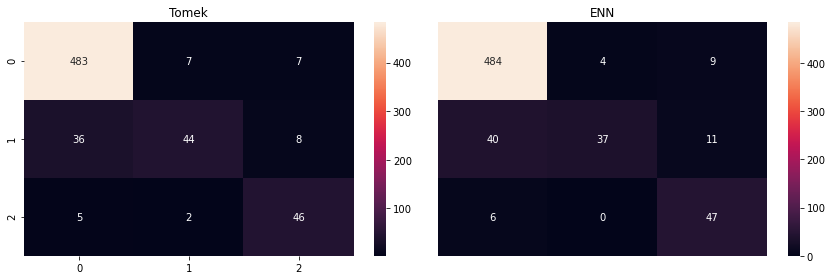

In [ ]:
fig, axList = plt.subplots(nrows=1, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10, 5)

for ax,lab in zip(axList, ['ADASYN', 'SMOTE-ENN']):
    sns.heatmap(cm[lab], ax=ax, vmax=55, annot=True, fmt='d', cbar=False)
    ax.set(title=lab)
    ax.set_xlabel('PREDICTED')
    ax.set_ylabel('ACTUAL')
    
plt.tight_layout()

In [ ]:
# Polynomial features performed worse than regular logistic regression

# Model 2 - Decision Tree

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier(random_state=531)

## 2a - Base Model w/ Balanced Classes

In [82]:
dt.fit(X_train_scaled, y_train)

print(f'nodes:{dt.tree_.node_count},depth:{dt.tree_.max_depth}')
y_test_preds = pd.Series(dt.predict(X_test_scaled), name=lab)

measure_error(y_test, y_test_preds, 'test')

nodes:187,depth:17


accuracy     0.920063
precision    0.875407
recall       0.869124
f1           0.872120
Name: test, dtype: float64

In [103]:
"""
X_train_SMOTE, y_train_SMOTE = SMOTE(random_state=531).fit_resample(X_train, y_train)
X_train_Tomek, y_train_Tomek = TomekLinks().fit_resample(X_train, y_train)
X_train_ENN, y_train_ENN = EditedNearestNeighbours().fit_resample(X_train, y_train)
X_train_SMOTEENN, y_train_SMOTEENN = SMOTEENN(random_state=531).fit_resample(X_train, y_train)
X_train_SMOTETomek, y_train_SMOTETomek = SMOTETomek(random_state=531).fit_resample(X_train, y_train)
X_train_ADASYN, y_train_ADASYN = ADASYN(random_state=531).fit_resample(X_train, y_train)
"""


In [ ]:
"""
y_test_pred = pd.DataFrame()
#y_train_pred = pd.DataFrame()
tree_shape = pd.DataFrame(columns=['sampler', 'nodes', 'depth'])

for lab, Xts, yts in zip(sampler_labels, Xtrains, ytrains):
    dt = dt.fit(Xts, yts)

    tree_shape_data = pd.DataFrame({'sampler':lab, 'nodes':dt.tree_.node_count, 
                                'depth':dt.tree_.max_depth}, index=[0])
    tree_shape = pd.concat([tree_shape, tree_shape_data], ignore_index=True)

    test_preds = pd.Series(dt.predict(X_test), name=lab)
    #train_preds = pd.Series(dt.predict(Xts), name=lab)
    y_test_pred = pd.concat([y_test_pred, test_preds], axis=1)
    #y_train_pred = pd.concat([y_train_pred, X_train_preds], axis=1)
    #y_test_pred = pd.concat(y_test_pred, axis=1)
    #y_train_pred = pd.concat(y_train_pred, axis=1)

tree_shape
"""

In [83]:
y_test_pred = pd.DataFrame()
tree_shape = pd.DataFrame(columns=['sampler', 'nodes', 'depth'])

for lab, Xts, yts in zip(sampler_labels, Xtrains, ytrains):
    dt.fit(Xts, yts)
    tree_shape.loc[len(tree_shape.index)] = [lab, dt.tree_.node_count, 
        dt.tree_.max_depth] 
    y_test_pred[lab] = pd.Series(dt.predict(X_test_scaled))

tree_shape

,sampler,nodes,depth
0,SMOTE,277,19
1,ADASYN,293,14
2,SMOTE-ENN,177,17
3,SMOTE-Tomek,271,19


In [84]:
error_measures = pd.DataFrame()

for lab, yts in zip(sampler_labels, ytrains):
    error_measures = pd.concat([error_measures, 
              measure_error(y_test, y_test_pred[lab], lab+'_test')], axis=1)
    
error_measures

,SMOTE_test,ADASYN_test,SMOTE-ENN_test,SMOTE-Tomek_test
accuracy,0.921630,0.894984,0.891850,0.921630
precision,0.862374,0.810956,0.793035,0.858949
recall,0.872296,0.820370,0.868904,0.869178
f1,0.867230,0.812876,0.826350,0.863804


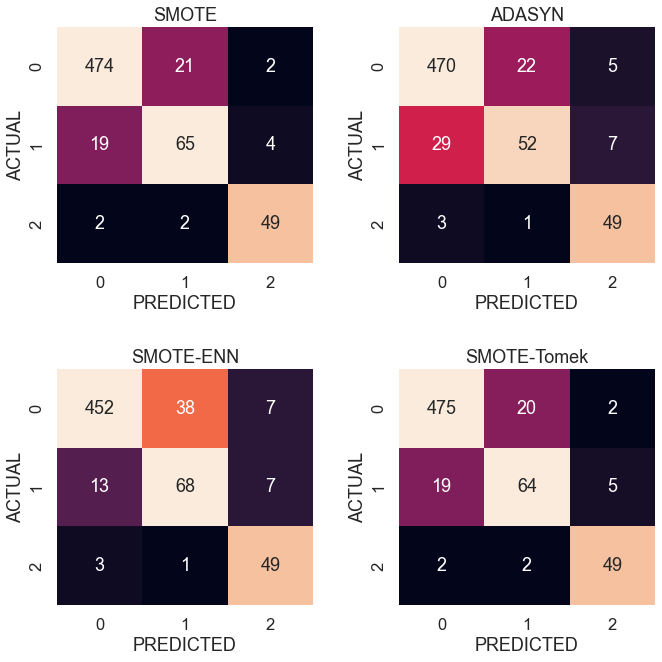

In [85]:
cm = dict()

for lab in sampler_labels:
    cm[lab] = confusion_matrix(y_test, y_test_pred[lab])

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10, 10)

for ax,lab in zip(axList, sampler_labels):
    sns.heatmap(cm[lab], ax=ax, vmax=55, annot=True, fmt='d', cbar=False)
    ax.set(title=lab)
    ax.set_xlabel('PREDICTED')
    ax.set_ylabel('ACTUAL')
    
plt.tight_layout(pad=2.0)

## 2b - Add GridSearch for max_depth and max_features

In [86]:
param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
              'max_features': range(1, len(dt.feature_importances_)+1)}

GR = GridSearchCV(DecisionTreeClassifier(random_state=531),
                  param_grid=param_grid,
                  scoring='recall_macro',
                  n_jobs=-1)

In [89]:
y_test_pred = pd.DataFrame()
importances_dt = pd.DataFrame()
tree_shape = pd.DataFrame(columns=['sampler', 'nodes', 'depth'])

for lab, Xts, yts in zip(sampler_labels, Xtrains, ytrains):
    GR = GR.fit(Xts, yts)
    y_test_pred[lab] = pd.Series(GR.predict(X_test_scaled), name=lab)
    importances_dt[lab] = pd.Series(GR.best_estimator_.feature_importances_)
    tree_shape.loc[len(tree_shape.index)] = [lab, GR.best_estimator_.tree_.node_count, 
        GR.best_estimator_.tree_.max_depth] 
    
importances_dt = importances_dt.set_index(feature_cols)

tree_shape

,sampler,nodes,depth
0,SMOTE,297,15
1,ADASYN,355,17
2,SMOTE-ENN,189,18
3,SMOTE-Tomek,271,19


In [90]:
error_measures = pd.DataFrame()

for lab, yts in zip(sampler_labels, ytrains):
    error_measures = pd.concat([error_measures, 
              measure_error(y_test, y_test_pred[lab], lab+'_test')], axis=1)
    
error_measures.T

,accuracy,precision,recall,f1
SMOTE_test,0.916928,0.835160,0.874017,0.853134
ADASYN_test,0.904389,0.821771,0.825626,0.822468
SMOTE-ENN_test,0.890282,0.800796,0.864500,0.829432
SMOTE-Tomek_test,0.921630,0.858949,0.869178,0.863804


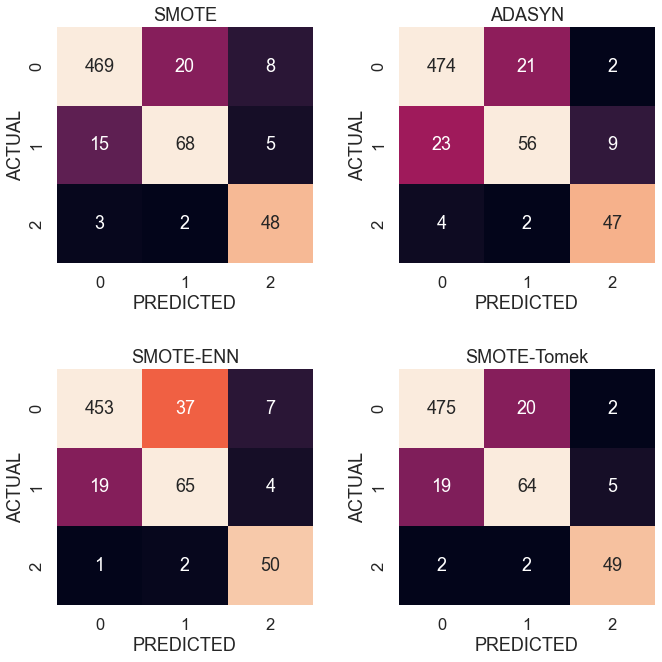

In [91]:
cm = dict()

for lab in sampler_labels:
    cm[lab] = confusion_matrix(y_test, y_test_pred[lab])
    
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10, 10)

for ax,lab in zip(axList, sampler_labels):
    sns.heatmap(cm[lab], ax=ax, vmax=55, annot=True, fmt='d', cbar=False)
    ax.set(title=lab)
    ax.set_xlabel('PREDICTED')
    ax.set_ylabel('ACTUAL')
    
plt.tight_layout(pad=2.0)

In [92]:
importances_dt_sorted = pd.DataFrame()

for cols in sampler_labels:
    importances_dt_sorted[cols] = pd.Series(importances_dt[cols].
            sort_values(ascending=False, ignore_index=True), name=cols)
            
importances_dt_sorted.reset_index(inplace=True)
importances_dt_sorted.rename(columns={'index':'feature_count'}, inplace=True)


In [94]:
importances_dt_SMOTEENN = pd.DataFrame(importances_dt['SMOTE-ENN']).sort_values(by='SMOTE-ENN', ascending=False)
importances_dt_SMOTEENN.reset_index(inplace=True)
importances_dt_SMOTEENN.reset_index(inplace=True)
importances_dt_SMOTEENN.rename(columns={'level_0':'feature_count', 'SMOTE-ENN':'feature_importance'}, inplace=True)
importances_dt_SMOTEENN

,feature_count,index,feature_importance
0,0,MSTV,0.270198
1,1,Mean,0.236180
2,2,MLTV,0.113692
3,3,ASTV,0.092747
4,4,ALTV,0.071156
5,5,LB,0.045950
6,6,Mode,0.041294
7,7,DP_fq,0.028848
8,8,AC_fq,0.026288
9,9,Nmax_fq,0.015173


<AxesSubplot:xlabel='feature_count', ylabel='feature_importance'>

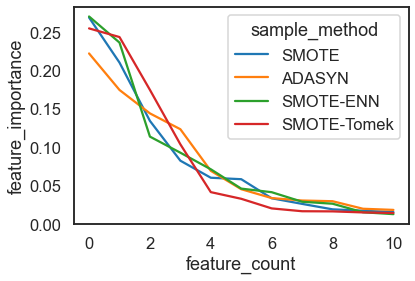

In [95]:
import seaborn as sns
importances_trim = importances_dt_sorted.iloc[:11, :]
importances_dt_sorted_melt = importances_trim.melt('feature_count', 
                                                   var_name='sample_method',  value_name='feature_importance')
sns.lineplot(data=importances_dt_sorted_melt, x='feature_count', y='feature_importance', hue='sample_method')

In [96]:
dt = DecisionTreeClassifier(random_state=531, max_depth=17, max_features=19)
dt = dt.fit(X_train_SMOTEENN, y_train_SMOTEENN)
y_test_pred = dt.predict(X_test)

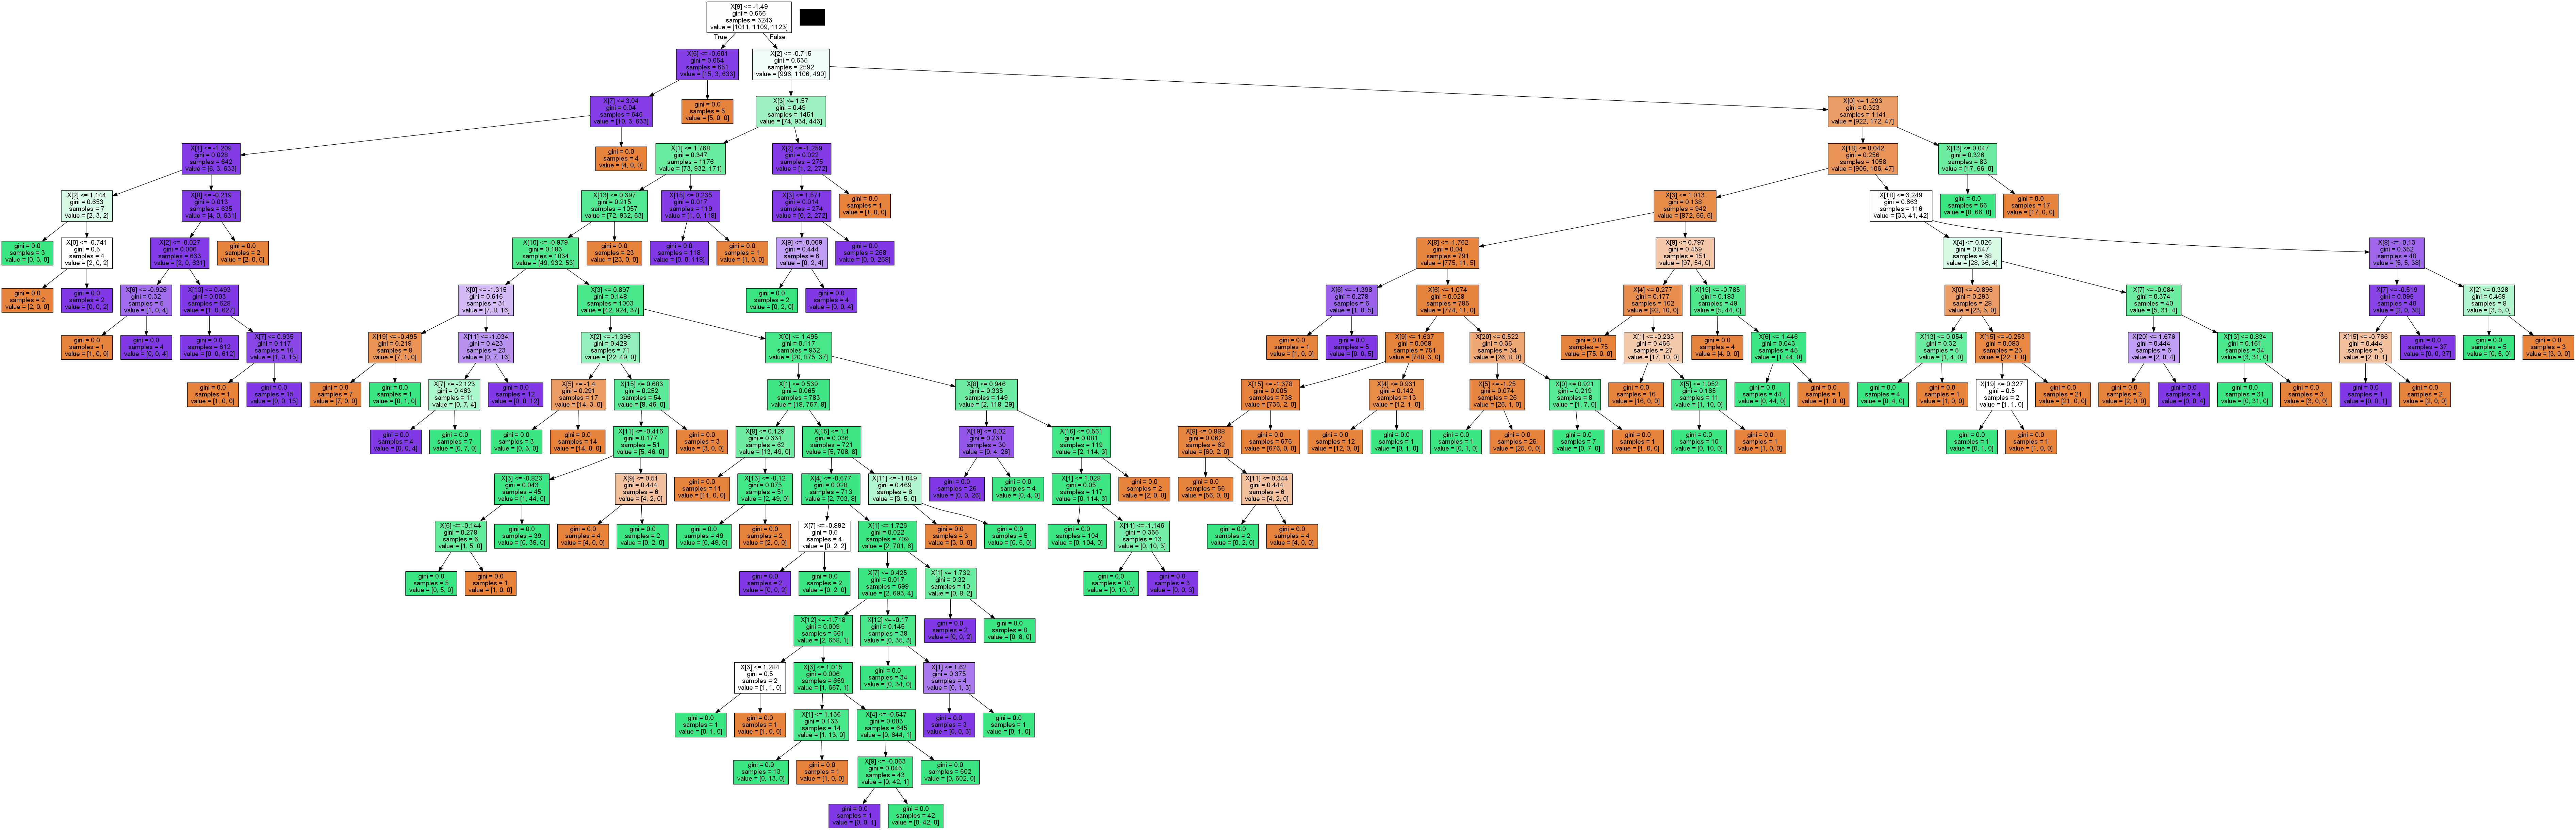

In [97]:
from io import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

# Create an output destination for the file
dot_data = StringIO()

export_graphviz(dt, out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# View the tree image
filename = 'fetal_toco_tree.png'
graph.write_png(filename)
Image(filename=filename) 

## 2c - Rerun with only most important features

In [101]:
param_grid = {'max_depth':range(1, 18+1, 2),
              'max_features': range(1, 6+1)}

GR = GridSearchCV(DecisionTreeClassifier(random_state=531),
                  param_grid=param_grid,
                  scoring='recall_macro',
                  n_jobs=-1)

In [99]:
y_test_pred = pd.DataFrame()
importances_dt = pd.DataFrame()
tree_shape = pd.DataFrame(columns=['sampler', 'nodes', 'depth'])

for lab, Xts, yts in zip(sampler_labels, Xtrains, ytrains):
    GR = GR.fit(Xts, yts)
    y_test_pred[lab] = pd.Series(GR.predict(X_test_scaled), name=lab)
    importances_dt[lab] = pd.Series(GR.best_estimator_.feature_importances_, name=lab)
    tree_shape.loc[len(tree_shape.index)] = [lab, GR.best_estimator_.tree_.node_count, 
        GR.best_estimator_.tree_.max_depth] 
    #print([lab], dict(nodes = GR.best_estimator_.tree_.node_count, depth=GR.best_estimator_.tree_.max_depth, params=GR.best_params_))
    
importances_dt = importances_dt.set_index(feature_cols)

tree_shape

,sampler,nodes,depth
0,SMOTE,297,15
1,ADASYN,355,17
2,SMOTE-ENN,189,18
3,SMOTE-Tomek,271,19


In [100]:
error_measures = pd.DataFrame()

for lab, yts in zip(sampler_labels, ytrains):
    error_measures = pd.concat([error_measures, 
              measure_error(y_test, y_test_pred[lab], lab+'_test')], axis=1)
    
error_measures.T

,accuracy,precision,recall,f1
SMOTE_test,0.916928,0.835160,0.874017,0.853134
ADASYN_test,0.904389,0.821771,0.825626,0.822468
SMOTE-ENN_test,0.890282,0.800796,0.864500,0.829432
SMOTE-Tomek_test,0.921630,0.858949,0.869178,0.863804


In [103]:
importances_dt[['SMOTE']].sort_values(by='SMOTE', ascending=False).iloc[0:6]

,SMOTE
ASTV,0.268838
Median,0.210149
ALTV,0.134171
DP_fq,0.082340
MSTV,0.060134
AC_fq,0.058218


## 2d - Try with Polynomial features

In [71]:
param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
              'max_features': range(1, 4+1)} #b/c we don't want more features than above

GR = GridSearchCV(DecisionTreeClassifier(random_state=531),
                  param_grid=param_grid,
                  scoring='recall_macro',
                  n_jobs=-1)

['SMOTE'] {'nodes': 595, 'depth': 17, 'params': {'max_depth': 17, 'max_features': 3}}
SMOTE time elapsed: 7.4 seconds
['ADASYN'] {'nodes': 355, 'depth': 17, 'params': {'max_depth': 17, 'max_features': 4}}
ADASYN time elapsed: 6.7 seconds
Runtime of the program is 14.1 seconds


In [108]:
y_test_pred = pd.DataFrame()
importances_dt_poly = pd.DataFrame()
tree_shape = pd.DataFrame(columns=['sampler', 'nodes', 'depth'])

for lab, Xts, yts in zip(sampler_labels, X_trains_poly, y_trains_poly):
    GR = GR.fit(Xts, yts)
    y_test_pred[lab] = pd.Series(GR.predict(X_test_scaled_poly), name=lab)
    importances_dt_poly[lab] = pd.Series(GR.best_estimator_.feature_importances_, name=lab)
    tree_shape.loc[len(tree_shape.index)] = [lab, GR.best_estimator_.tree_.node_count, 
        GR.best_estimator_.tree_.max_depth]

importances_dt = importances_dt.set_index(feature_cols)

tree_shape

,sampler,nodes,depth
0,SMOTE,507,17
1,ADASYN,285,15


In [72]:
importances_dt_poly.reindex(feature_cols_poly, copy=False)

,SMOTE,ADASYN
LB,NaN,NaN
ASTV,NaN,NaN
MSTV,NaN,NaN
ALTV,NaN,NaN
MLTV,NaN,NaN
...,...,...
DP_fq Nmax_fq,NaN,NaN
DP_fq Nzeros_fq,NaN,NaN
Nmax_fq^2,NaN,NaN
Nmax_fq Nzeros_fq,NaN,NaN


In [109]:
error_measures = pd.DataFrame()

for lab, yts in zip(sampler_labels, y_trains_poly):
    error_measures = pd.concat([error_measures, 
                               measure_error(y_test, y_test_pred[lab], lab+'_test')], axis=1)
    
error_measures.T

,accuracy,precision,recall,f1
SMOTE_test,0.860502,0.751958,0.751931,0.751641
ADASYN_test,0.885580,0.782615,0.849981,0.811556


## 2e - Add Ensemble methods

In [114]:
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier

### Boosting

In [115]:
param_grid = {'n_estimators': [250, 300, 350],
             'learning_rate': [0.5, 0.6, 0.7],
             'subsample': [0.4, 0.5, 0.6]}

GR_gb = GridSearchCV(GradientBoostingClassifier(random_state=531, warm_start=True), param_grid=param_grid, 
                      scoring='recall_macro', n_jobs = -1)

In [116]:
GR_gb = GR_gb.fit(X_train_SMOTEENN, y_train_SMOTEENN)

y_test_pred = GR_gb.predict(X_test_scaled)
importances_gb = pd.DataFrame(GR_gb.best_estimator_.feature_importances_, index=feature_cols)

In [117]:
error_measures = pd.DataFrame()

error_measures = pd.concat([error_measures,
                               measure_error(y_test, y_test_pred, 'SMOTEENN_test')], axis=1)
    
error_measures

,SMOTEENN_test
accuracy,0.935737
precision,0.899754
recall,0.909504
f1,0.903245


<AxesSubplot:>

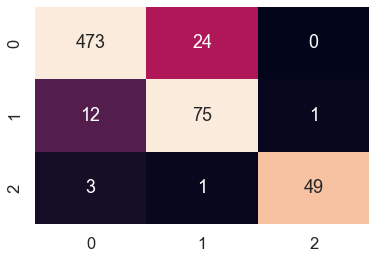

In [122]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, vmax=55, annot=True, fmt='d', cbar=False)
#ax.set(title='SMOTE-ENN')
#ax.set_xlabel('PREDICTED')
#ax.set_ylabel('ACTUAL')

In [123]:
importances_gb_sorted = pd.DataFrame(importances_gb.sort_values(by=0, ascending=False))
importances_gb_sorted.reset_index(inplace=True)
importances_gb_sorted.reset_index(inplace=True)
importances_gb_sorted.rename(columns={'level_0':'feature_count', 0:'feature_importance'}, inplace=True)
importances_gb_trim = importances_gb_sorted.iloc[:11, :]
importances_gb_trim

,feature_count,index,feature_importance
0,0,ALTV,0.271104
1,1,ASTV,0.172327
2,2,Mean,0.147938
3,3,AC_fq,0.137646
4,4,DP_fq,0.073868
5,5,MSTV,0.046113
6,6,Mode,0.039975
7,7,Median,0.020863
8,8,LB,0.017788
9,9,Min,0.014574


<AxesSubplot:xlabel='feature_count', ylabel='feature_importance'>

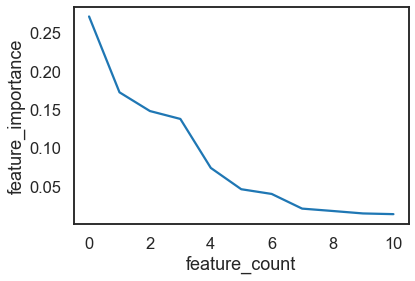

In [124]:
sns.lineplot(data=importances_gb_trim, x='feature_count', y='feature_importance')

# Model 3 - Random Forest

In [125]:
rf = RandomForestClassifier(random_state=531, oob_score=True, warm_start=True, n_jobs=-1)
oob_list = list()

for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    rf.set_params(n_estimators=n_trees)
    rf.fit(X_train_SMOTEENN, y_train_SMOTEENN)
    oob_error = 1 - rf.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

rf_oob_df

c:\Users\14126\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Runtime of the program is 1.5 seconds


,oob
n_trees,
15.0,0.019735
20.0,0.016651
30.0,0.014184
40.0,0.012334
50.0,0.011409
100.0,0.009559
150.0,0.010176
200.0,0.009251
300.0,0.010176


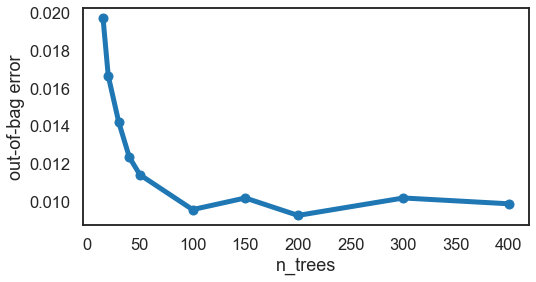

In [126]:
sns.set_context('talk')
sns.set_style('white')

ax = rf_oob_df.plot(legend=False, marker='o', figsize=(8, 4), linewidth=5)
ax.set(ylabel='out-of-bag error');

In [127]:
rf = RandomForestClassifier(random_state=531, n_estimators=100, warm_start=True, n_jobs=-1)
rf.fit(X_train_SMOTEENN, y_train_SMOTEENN)
y_test_pred = rf.predict(X_test_scaled)
importances_rf = pd.DataFrame(rf.feature_importances_, index=feature_cols)

In [128]:
error_measures = pd.DataFrame()

error_measures = pd.concat([error_measures, 
                               measure_error(y_test, y_test_pred, 'SMOTE-ENN_test')], axis=1)
    
error_measures

,SMOTE-ENN_test
accuracy,0.926332
precision,0.859518
recall,0.890509
f1,0.874116


<AxesSubplot:>

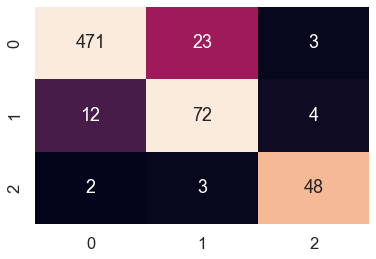

In [130]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, vmax=55, annot=True, fmt='d', cbar=False)

In [131]:
importances_rf_sorted = pd.DataFrame(importances_rf.sort_values(by=0, ascending=False))
importances_rf_sorted.reset_index(inplace=True)
importances_rf_sorted.reset_index(inplace=True)
importances_rf_sorted.rename(columns={'level_0':'feature_count', 0:'feature_importance'}, inplace=True)
importances_rf_sorted

,feature_count,index,feature_importance
0,0,ALTV,0.120231
1,1,ASTV,0.101985
2,2,Mean,0.100618
3,3,MSTV,0.094703
4,4,AC_fq,0.085675
5,5,Median,0.080714
6,6,MLTV,0.077316
7,7,DP_fq,0.058181
8,8,Mode,0.052654
9,9,Variance,0.036587


<AxesSubplot:xlabel='feature_count', ylabel='feature_importance'>

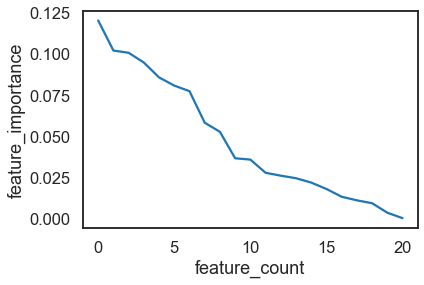

In [132]:
sns.lineplot(data=importances_rf_sorted, x='feature_count', y='feature_importance')

# Appendix

## Full List of Features with Definitions

Features: <br>
FileName: of CTG examination <br>
Date: of the examination <br>
b: start instant <br>
e: end instant <br>
LBE: baseline value (medical expert) <br>
LB: baseline value (SisPorto) <br>
AC: accelerations (SisPorto) <br>
FM: foetal movement (SisPorto)<br>
UC: uterine contractions (SisPorto)<br>
ASTV: percentage of time with abnormal short term variability (SisPorto)<br>
mSTV: mean value of short term variability (SisPorto)<br>
ALTV: percentage of time with abnormal long term variability (SisPorto)<br>
mLTV: mean value of long term variability (SisPorto)<br>
DL: light decelerations<br>
DS: severe decelerations<br>
DP: prolongued decelerations<br>
DR: repetitive decelerations<br>
Width: histogram width<br>
Min: low freq. of the histogram<br>
Max: high freq. of the histogram<br>
Nmax: number of histogram peaks<br>
Nzeros: number of histogram zeros<br>
Mode: histogram mode<br>
Mean: histogram mean<br>
Median: histogram median<br>
Variance: histogram variance<br>
Tendency: histogram tendency: -1=left assymetric; 0=symmetric; 1=right assymetric<br>
A: calm sleep<br>
B: REM sleep<br>
C: calm vigilance<br>
D: active vigilance<br>
SH: shift pattern (A or Susp with shifts)<br>
AD: accelerative/decelerative pattern (stress situation)<br>
DE: decelerative pattern (vagal stimulation)<br>
LD: largely decelerative pattern<br>
FS: flat-sinusoidal pattern (pathological state)<br>
SUSP: suspect pattern<br>
CLASS: Class code (1 to 10) for classes A to SUSP<br>
NSP:- Normal=1; Suspect=2; Pathologic=3<br>